In [1]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
vocab_size = 5000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-08-04 09:13:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2020-08-04 09:13:43 (223 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [18]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [47]:
learnshdfn = tf.keras.optimizers.schedules.ExponentialDecay(0.001,70,0.96,True)

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=learnshdfn),metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 32, 16)            80000     
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 80,289
Trainable params: 80,289
Non-trainable params: 0
_________________________________________________________________


In [50]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.5855 - accuracy: 0.6969 - val_loss: 0.4408 - val_accuracy: 0.8201
Epoch 2/30
625/625 - 2s - loss: 0.3692 - accuracy: 0.8480 - val_loss: 0.3700 - val_accuracy: 0.8471
Epoch 3/30
625/625 - 2s - loss: 0.3124 - accuracy: 0.8737 - val_loss: 0.3580 - val_accuracy: 0.8423
Epoch 4/30
625/625 - 2s - loss: 0.2855 - accuracy: 0.8834 - val_loss: 0.3514 - val_accuracy: 0.8490
Epoch 5/30
625/625 - 2s - loss: 0.2700 - accuracy: 0.8902 - val_loss: 0.3502 - val_accuracy: 0.8504
Epoch 6/30
625/625 - 2s - loss: 0.2610 - accuracy: 0.8945 - val_loss: 0.3499 - val_accuracy: 0.8501
Epoch 7/30
625/625 - 2s - loss: 0.2544 - accuracy: 0.8967 - val_loss: 0.3503 - val_accuracy: 0.8496
Epoch 8/30
625/625 - 2s - loss: 0.2500 - accuracy: 0.8990 - val_loss: 0.3503 - val_accuracy: 0.8499
Epoch 9/30
625/625 - 2s - loss: 0.2477 - accuracy: 0.9011 - val_loss: 0.3505 - val_accuracy: 0.8489
Epoch 10/30
625/625 - 2s - loss: 0.2448 - accuracy: 0.9018 - val_loss: 0.3507 - val_accuracy: 0.8489

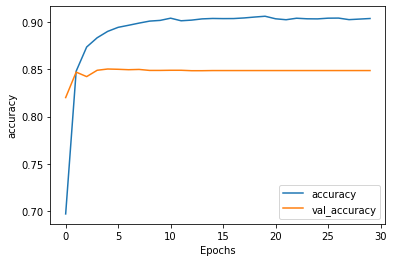

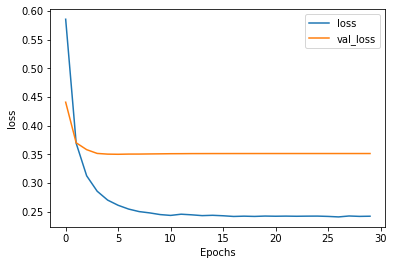

In [51]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [52]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.45239577]
 [0.21509159]]
